In [1]:
from random import seed, random, randrange
from csv import reader
from math import exp
import os 
import numpy as np
import pickle
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

In [2]:
data_path = 'C:/Users/tianyi/Northeastern University/Machine Learning Final Project - Music Classification - Documents'
myspace_mp3s_path = '%s/myspace_mp3s' % data_path
metadata_path = '%s/metadata.json.gz' % myspace_mp3s_path
genre_map_path = '%s/genre_map.pkl' % myspace_mp3s_path
mfcc_path = '%s/audio_features/mfcc' % data_path

# creating nerual network from scratch

In [3]:
def initialize_network(n_inputs, n_hidden, n_outputs): 
    '''
    Initialize a neural network
    organize layers as arrays of dictionaries
    '''
    layer_input = []
    for i in range(n_inputs): 
        layer_input.append({})
    
    # n hidden neurons for the hidden layer, and each neuron has n inputs + 1 weights, 
    # one for each input column in the dataset and another for the bias. 
    layer_hidden = []
    for i in range(n_hidden): 
        w = []
        b = random()
        for j in range(n_inputs): 
            w.append(random())
        layer_hidden.append({'w': w, 'b': b, 'o': 0, 'e': 0})
        
    #  n outputs neurons in the output layer that links to the hidden layer, 
    # each with n hidden + 1 weights. 
    layer_output = []
    for i in range(n_outputs): 
        w = []
        b = random()
        for j in range(n_hidden): 
            w.append(random())
        layer_output.append({'w': w, 'b': b, 'o': 0, 'e': 0})
    
    # treat the whole network as an array of layers
    network = [layer_input, layer_hidden, layer_output]
    
    return network


def activate(weights, inputs): 
    '''
    Calculate neuron activation for an input
    weights shape: n_neurons_hidden_layer x  n_neurons_inputs_layer
    inputs shape: n_neurons_inputs_layer
    result shape:  n_neurons_hidden_layer * 1
    '''

    res = []
    for hid in range(len(weights)): 
        sum = 0.0
        for inp in range(len(inputs)): 
            sum += inputs[inp] * weights[hid]['w'][inp]
        
        sum += weights[hid]['b']
        
        z = transfer(sum)
        
        res.append(z)
        
    return res


def transfer(activation): 
    '''
    Transfer neuron activation
    '''
    return (1.0 / (1.0 + exp(-activation)));


def forward_propagate(network, row): 
    '''
    Forward propagate input to a network output
    '''
    
    # input layer -> hidden layer
    hidden_output = activate(network[1], row)
    for i in range(len(hidden_output)): 
        network[1][i]['o'] = hidden_output[i]

    
    # hidden layer -> output layer
    output = activate(network[2], hidden_output)
    for i in range(len(output)): 
        network[2][i]['o'] = output[i]


def transfer_derivative(output):
    '''
    Calculate the derivative of an neuron output
    '''
    return output * (1.0 - output)


def backward_propagate_error(network, expected):
    '''
    Backpropagate error and store in neurons
    '''
    error_output = []
    for out in range(len(network[2])): 
        error = expected[out] - network[2][out]['o']
        error_output.append(error)
        network[2][out]['e'] = error
        
    for hid in range(len(network[1])): 
        error = 0.0
        for out in range(len(network[2])): 
            error += error_output[out] * network[2][out]['w'][hid]
            
        error *= transfer_derivative(network[1][hid]['o'])
        
        network[1][hid]['e'] = error
    

def back_propagation(train, test, l_rate, n_epoch, n_hidden):
    '''
    Backpropagation Algorithm With Stochastic Gradient Descent
    '''
    (X_train, y_train) = train
    (X_test, y_test) = test
    n_inputs = len(X_train[0])
    n_outputs = len(y_train[0])
    network = initialize_network(n_inputs, n_hidden, n_outputs)
    
    train_network(network, train, l_rate, n_epoch, n_outputs, test)
    print('end of training')

    # evaluate 
    pred_y = []
    for X in X_test: 
        y = predict(network, X)
        pred_y.append(y)
        
    y_pred = []
    acc = accuracy_metric(y_test, pred_y)
    print('final testing acc:', acc)
    y_pred = get_predicted(y_test, pred_y)
    return acc,y_pred


def update_weights(network, row, l_rate):
    '''
    Update network weights with error
    '''
    # Update the weights for the output layer
    for out in range(len(network[2])): 
        for hid in range(len(network[1])): 
            w = network[2][out]['w'][hid]
            w += (l_rate * network[2][out]['e'] * network[1][hid]['o'])
            network[2][out]['w'][hid] = w
            
        b = network[2][out]['b']
        b += (l_rate * network[2][out]['e'])
        network[2][out]['b'] = b
        
    # Update the weights for the hidden layer
    for hid in range(len(network[1])): 
        for inp in range(len(network[0])): 
            w = network[1][hid]['w'][inp]
            w += (l_rate * network[1][hid]['e'] * row[inp])
            network[1][hid]['w'][inp] = w
        
        b = network[1][hid]['b']
        b += (l_rate * network[1][hid]['e'])
        network[1][hid]['b'] = b

def train_network(network, train, l_rate, n_epoch, n_outputs, test): 
    '''
    Train a network for a fixed number of epochs
    '''
    (X_train, y_train) = train
    (X_test, y_test) = test
    
    # updating the network for each row in the training dataset inside each epoch.
    for epoch in range(n_epoch): 
        # evaluate for every 10 epoch: 
        if epoch % 10 == 0: 
            print('epoch:', epoch)
            y_pred_train = []
            pred_y = []
            for X in X_train: 
                y = predict(network, X)
                pred_y.append(y)

            acc = accuracy_metric(y_train, pred_y)
            print('train acc:', acc)

            pred_y = []
            y_pred_test = []
            for X in X_test: 
                y = predict(network, X)
                pred_y.append(y)

            acc = accuracy_metric(y_test, pred_y)
            print('test acc:', acc)

        for i in range(len(X_train)): 
            X = X_train[i]
            y = y_train[i]
            forward_propagate(network, X)
            backward_propagate_error(network, y)
            update_weights(network, X, l_rate)


def predict(network, row):
    '''
    Make a prediction with a network
    '''
    forward_propagate(network, row)
    y = []
    for out in range(len(network[2])): 
        output = network[2][out]['o']
        y.append(output)
        
    return y


def arg_max(output): 
    '''
    find max element's index of array output
    '''
    max_index = 0
    max = output[0]
    for i in range(len(output)): 
        if output[i] > max: 
            max_o = output[i]
            max_index = i

    return max_index
        

def accuracy_metric(actual, predicted):
    '''
    Calculate accuracy percentage
    '''
    total = len(actual)
    correct = 0
    y_pred = []
    for i in range(total): 
        if arg_max(actual[i]) == arg_max(predicted[i]): 
            correct += 1
         
    acc = correct / total
    return acc

def get_predicted(actual, predicted):
    '''
    get predicted label
    '''
    total = len(actual)
    correct = 0
    y_pred = []
    for i in range(total):
        y_pred.append(arg_max(predicted[i]))

    return y_pred

# shuffle the data and get mfcc

In [4]:
def shuffle_data(x, y):
    '''
    Shuffles x and y data. 
    '''
    idx = np.arange(x.shape[0])
    np.random.shuffle(idx)
    x = x[idx]
    y = y[idx]
    
    return x, y


def normalize_data(x):
    '''
    Normalizes x data. 
    '''
    return (x - x.mean()) / x.std()


def get_mfccs(mfcc_path, genres, lab_idx, max_recs):
    '''
    Open and process mfcc and return as x and y arrays.
    '''
    
    # save all x and y values
    mfccs = []
    y=[]
    i = 0
    
    # loop over each genre we are working with
    for genre in genres:
        print("genre: ", genre)
        
        # extract path to all song mfccs in current genre
        genre_path = '%s/%s' % (mfcc_path, genre)
        ct = 0
        
        # loop over each mfcc in current genre
        for fn in os.listdir(genre_path): 
            
            i += 1
            # get path to mfcc
            fp = '%s/%s' % (genre_path, fn)
            
            # load mfcc and transpose/take mean
            mfcc = np.load(fp) 
            mfcc = np.mean(mfcc.T,axis=0)
            if np.isnan(np.sum(mfcc)):
                print('Error with mfcc file')
                continue
            else:
                mfccs.append(mfcc)
            
            # append target label to list
            y.append(lab_idx[genre])
            ct += 1
            if ct == max_recs: 
                break
    # normalize data and create arrays
    x = np.array(mfccs)
    x = normalize_data(x) # error with normalizing, will scale later
    y = np.array(y)
    
    return shuffle_data(x, y)


SEED = 20211130

# genre counts (# samples per genre)
genre_cts = {}
for genre in os.listdir(mfcc_path):
    genre_path = '%s/%s' % (mfcc_path, genre)
    genre_cts[genre] = len(os.listdir(genre_path))
    
# print counts for each genre
for g in sorted(genre_cts, key=genre_cts.get, reverse=True):
    print(g, genre_cts[g])


rock 13158
metal 8782
alternative 8778
rap 5906
dance 5624
pop 4684
jazz 4552
hip_hop 4526
experimental 3686
other 3544
world 2225
electronic 2127
folk 1804
punk 1729
blues 1472
ambient 1299
reggae 1114
goth 722
acoustic 678
country 533
house 512
classical 486
spiritual 369
oldies 248
progressive 221
funk 142
easy_listening 131
spoken_word 130
bluegrass 47
industrial 44
showtunes 38
disco 23


In [5]:
genres = list(genre_cts.keys())
all_genres = ['rock', 'metal','alternative','rap','dance']

#all_genres =  list(genre_cts.keys())
print(len(genres))
# all_genres = ['jazz', 'reggae']
print(all_genres)


lab_idx = {g:i for i,g in enumerate(all_genres)}
print('lab_idx', lab_idx)


min_recs = min([genre_cts[g] for g in all_genres]) 
print('min_recs', min_recs)


x, y = get_mfccs(mfcc_path, all_genres, lab_idx,min_recs)
print('shape:', x.shape, y.shape)

32
['rock', 'metal', 'alternative', 'rap', 'dance']
lab_idx {'rock': 0, 'metal': 1, 'alternative': 2, 'rap': 3, 'dance': 4}
min_recs 5624
genre:  rock
genre:  metal
genre:  alternative
genre:  rap
genre:  dance
shape: (28120, 20) (28120,)


In [6]:
seed(SEED)

l_rate = 0.01
n_epoch = 200
n_hidden = 128

x = x.tolist()

# convert y to one-hot

y = y.tolist()
for i in range(len(y)): 
    if y[i] == 0: 
        y[i] = [1, 0, 0, 0,0]
        continue
        
    if y[i] == 1: 
        y[i] = [0, 1, 0, 0,0]
        continue
        
    if y[i] == 2: 
        y[i] = [0, 0, 1, 0,0]
        continue

    if y[i] == 3: 
        y[i] = [0, 0, 0, 1,0]
        continue
            
    if y[i] == 4: 
        y[i] = [0, 0, 0, 0,1]
        continue

X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)
train = (X_train, y_train)
test = (X_test, y_test)
# train and evaluate
acc_score,y_pred = back_propagation(train, test, l_rate, n_epoch, n_hidden)

epoch: 0
train acc: 0.18696657183499288
test acc: 0.19203413940256045
epoch: 10
train acc: 0.4329658605974395
test acc: 0.43385490753911804
epoch: 20
train acc: 0.43643314366998576
test acc: 0.4345661450924609
epoch: 30
train acc: 0.44172297297297297
test acc: 0.4366998577524893
epoch: 40
train acc: 0.4439900426742532
test acc: 0.44185633001422475
epoch: 50
train acc: 0.44434566145092463
test acc: 0.44256756756756754
epoch: 60
train acc: 0.4438122332859175
test acc: 0.44310099573257467
epoch: 70
train acc: 0.44456792318634425
test acc: 0.441678520625889
epoch: 80
train acc: 0.4455014224751067
test acc: 0.44274537695590327
epoch: 90
train acc: 0.4458570412517781
test acc: 0.44274537695590327
epoch: 100
train acc: 0.44714615931721197
test acc: 0.44256756756756754
epoch: 110
train acc: 0.4467016358463727
test acc: 0.4445234708392603
epoch: 120
train acc: 0.4472350640113798
test acc: 0.4436344238975818
epoch: 130
train acc: 0.44714615931721197
test acc: 0.4423897581792319
epoch: 140
train 

[[0, 0, 0, 1, 0], [0, 0, 1, 0, 0], [0, 1, 0, 0, 0], [0, 1, 0, 0, 0], [0, 1, 0, 0, 0], [1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 0, 0, 1], [0, 0, 1, 0, 0], [0, 0, 0, 1, 0], [0, 1, 0, 0, 0], [0, 1, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 1, 0], [0, 0, 0, 0, 1], [0, 0, 1, 0, 0], [0, 0, 0, 0, 1], [1, 0, 0, 0, 0], [0, 0, 0, 1, 0], [0, 0, 1, 0, 0], [0, 1, 0, 0, 0], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [1, 0, 0, 0, 0], [0, 0, 1, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 1, 0], [0, 0, 0, 0, 1], [0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 1, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 1, 0], [0, 1, 0, 0, 0], [0, 0, 0, 1, 0], [1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 0, 1, 0], [0, 0, 0, 1, 0], [0, 1, 0, 0, 0], [0, 0, 0, 0, 1], [0, 1, 0, 0, 0], [0, 0, 0, 1, 0], [0, 1, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 1, 0, 0, 0], [0, 0, 0, 1, 0], [1, 0, 0, 0, 0], [0, 0, 0, 1, 0], [0, 0, 0, 1, 0], [1, 0, 0, 0, 0], [0, 0, 0, 1, 0], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 1, 0, 0, 0], [0, 0, 0, 1, 

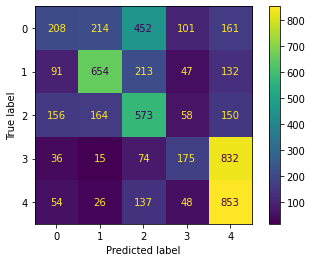

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
print(y_test)
label_5 = np.array([0,1,2,3,4])
rounded_y=np.argmax(y_test, axis=1)
print(rounded_y)
print(y_pred)
print(classification_report(rounded_y, y_pred))
cm = confusion_matrix(rounded_y, y_pred, labels=label_5)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=label_5)
disp.plot()
plt.show()

In [8]:
all_genres1 =  list(genre_cts.keys())
print(len(genres))
# all_genres = ['jazz', 'reggae']
print(all_genres1)


lab_idx = {g:i for i,g in enumerate(all_genres1)}
print('lab_idx', lab_idx)


min_recs = min([genre_cts[g] for g in all_genres1]) 
print('min_recs', min_recs)


x1, y1 = get_mfccs(mfcc_path, all_genres1, lab_idx,min_recs)
print('shape:', x1.shape, y1.shape)

32
['acoustic', 'alternative', 'ambient', 'bluegrass', 'blues', 'classical', 'country', 'dance', 'disco', 'easy_listening', 'electronic', 'experimental', 'folk', 'funk', 'goth', 'hip_hop', 'house', 'industrial', 'jazz', 'metal', 'oldies', 'other', 'pop', 'progressive', 'punk', 'rap', 'reggae', 'rock', 'showtunes', 'spiritual', 'spoken_word', 'world']
lab_idx {'acoustic': 0, 'alternative': 1, 'ambient': 2, 'bluegrass': 3, 'blues': 4, 'classical': 5, 'country': 6, 'dance': 7, 'disco': 8, 'easy_listening': 9, 'electronic': 10, 'experimental': 11, 'folk': 12, 'funk': 13, 'goth': 14, 'hip_hop': 15, 'house': 16, 'industrial': 17, 'jazz': 18, 'metal': 19, 'oldies': 20, 'other': 21, 'pop': 22, 'progressive': 23, 'punk': 24, 'rap': 25, 'reggae': 26, 'rock': 27, 'showtunes': 28, 'spiritual': 29, 'spoken_word': 30, 'world': 31}
min_recs 23
genre:  acoustic
genre:  alternative
genre:  ambient
genre:  bluegrass
genre:  blues
genre:  classical
genre:  country
genre:  dance
genre:  disco
genre:  easy

In [9]:
l_rate = 0.01
n_epoch = 500
n_hidden = 128

x1 = x1.tolist()

# convert y to one-hot

y1 = y1.tolist()
def transfer_y(x):
    tmp_y = []
    modified_y = []
    for i in range(len(genres)):
        tmp_y.append(0)
    modified_y = tmp_y
    modified_y[x] = 1
    
    return modified_y

for i in range(len(y1)): 

    y1[i] = transfer_y(y1[i])

In [10]:


X_train, X_test, y_train, y_test = train_test_split(x1,y1, test_size=0.2, random_state=42)
train = (X_train, y_train)
test = (X_test, y_test)
# train and evaluate
back_propagation(train, test, l_rate, n_epoch, n_hidden)

epoch: 0
train acc: 0.027210884353741496
test acc: 0.02702702702702703
epoch: 10
train acc: 0.0391156462585034
test acc: 0.0
epoch: 20
train acc: 0.0391156462585034
test acc: 0.0
epoch: 30
train acc: 0.0391156462585034
test acc: 0.0
epoch: 40
train acc: 0.0391156462585034
test acc: 0.0
epoch: 50
train acc: 0.0391156462585034
test acc: 0.0
epoch: 60
train acc: 0.0391156462585034
test acc: 0.0
epoch: 70
train acc: 0.0391156462585034
test acc: 0.0
epoch: 80
train acc: 0.04931972789115646
test acc: 0.013513513513513514
epoch: 90
train acc: 0.05102040816326531
test acc: 0.04054054054054054
epoch: 100
train acc: 0.05612244897959184
test acc: 0.0472972972972973
epoch: 110
train acc: 0.047619047619047616
test acc: 0.0472972972972973
epoch: 120
train acc: 0.04591836734693878
test acc: 0.0472972972972973
epoch: 130
train acc: 0.04931972789115646
test acc: 0.0472972972972973
epoch: 140
train acc: 0.04931972789115646
test acc: 0.05405405405405406
epoch: 150
train acc: 0.05102040816326531
test acc:

(0.033783783783783786,
 [31,
  31,
  31,
  12,
  31,
  31,
  30,
  31,
  12,
  3,
  31,
  31,
  31,
  31,
  29,
  29,
  31,
  31,
  31,
  29,
  31,
  31,
  21,
  31,
  21,
  31,
  31,
  31,
  31,
  23,
  31,
  31,
  0,
  31,
  31,
  12,
  31,
  31,
  31,
  30,
  31,
  31,
  31,
  23,
  31,
  31,
  31,
  31,
  21,
  27,
  31,
  29,
  31,
  31,
  30,
  29,
  31,
  27,
  31,
  27,
  31,
  31,
  31,
  27,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  30,
  31,
  31,
  31,
  31,
  31,
  20,
  30,
  31,
  31,
  27,
  31,
  12,
  31,
  31,
  31,
  3,
  12,
  11,
  12,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  29,
  31,
  31,
  31,
  31,
  31,
  29,
  12,
  29,
  31,
  31,
  20,
  31,
  31,
  31,
  31,
  12,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31])